# Capstone Project - Stock Analysis & Portfolio Management
#####  <font color = grey> ------ Prashanta Das

### Problem Statement, Objective and Overview

<b>Objective:</b>
- We have been tasked to understand the client's background and requirement related to her investments.
- From a given pool of 12 US stocks we have to prepare a portfolio which is suitable for the client.
- We also have to validate the same.

<b>Overview of the Process:</b>
- After understanding the client's background and requirement, we have to prepare a portfolio which genetaes healthy and stable returns.
- First step would be to look at the key parameters of these stocks within their industry and with respect to the benckmark.
- Using those parameters, creating an automated portfolio of stocks using Efficient Frontier from Modern Portfolio Theory.
- Then we need to validate whether that portfolio can generate similar returns going forword using a time series forecasting technique.
- We have tried to break the whole process down into a tree diagram which is shown below.
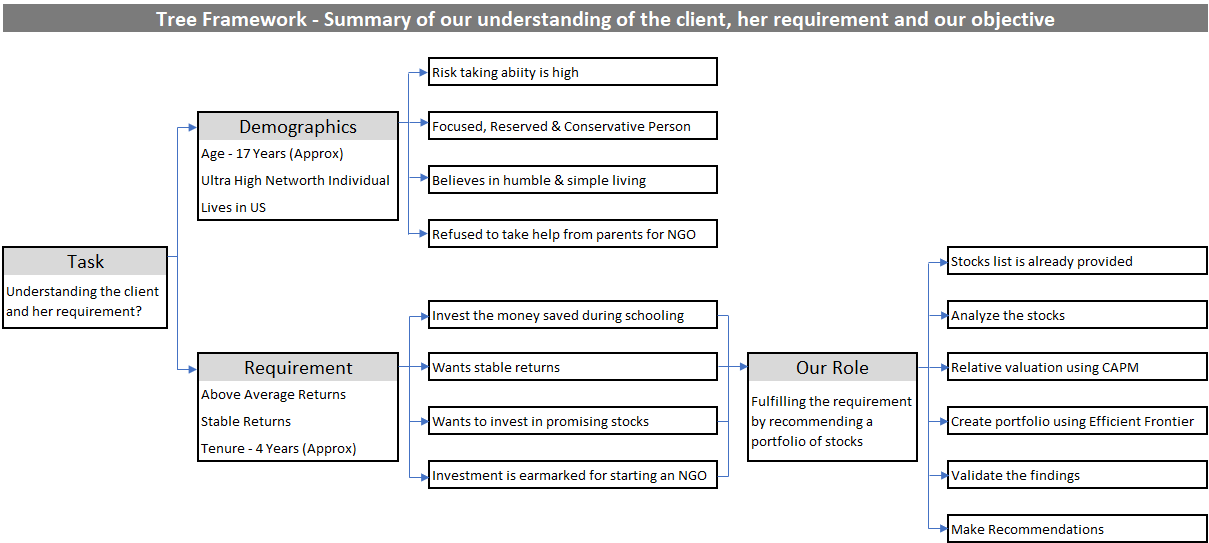

#### Loading the required libraries
<font color = 'red'><b> Used Auto ARIMA - Please Install pmdarima by "pip install pmdarima" in the jupiter notebook.</font>

In [ ]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

# For Time series Decomposing
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.optimize as sco

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# For different time series models
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For Automating stationary tests and Auto ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

# For evaluating the results of time series forecasting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# To show more rows and columns
pd.set_option('display.max_rows',200, 'display.max_columns',50)

#### Loading the dataframe - Importing only the required columns
- We are importing the daily Adjusted closing price of the stocks as it also includes the dividend payments.
- It will be very useful for higher dividend paying stocks like Merck, otherwise we will be under reporting the actual returns.

In [ ]:
# Benchmark
sp500 = pd.read_csv('S&P500.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
# Technology
alphabet = pd.read_csv('GOOG.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
amazon = pd.read_csv('AMZN.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
apple = pd.read_csv('AAPL.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
# Finance
creditSuisse = pd.read_csv('CS.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
deutscheBank = pd.read_csv('DB.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
goldmanSachs = pd.read_csv('GS.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
# Aviation
americanAir = pd.read_csv('AAL.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
alaskaAir = pd.read_csv('ALK.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
hawaiian = pd.read_csv('HA.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
# Pharma & Healthcare
bauschHealth = pd.read_csv('BHC.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
johnson = pd.read_csv('JNJ.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')
merck = pd.read_csv('MRK.csv', usecols = ['Date','Adj Close','Volume'], index_col = 'Date')

## <font color = 'blue'>Data Preparation</font>

In [ ]:
# Renaming the columns
sp500 = sp500.rename(columns = {'Adj Close':'sp500', 'Volume':'sp500_Vol',})
alphabet = alphabet.rename(columns = {'Adj Close':'alphabet', 'Volume':'alphabet_Vol',})
amazon = amazon.rename(columns = {'Adj Close':'amazon', 'Volume':'amazon_Vol',})
apple = apple.rename(columns = {'Adj Close':'apple', 'Volume':'apple_Vol',})
creditSuisse = creditSuisse.rename(columns = {'Adj Close':'creditSuisse', 'Volume':'creditSuisse_Vol',})
deutscheBank = deutscheBank.rename(columns = {'Adj Close':'deutscheBank', 'Volume':'deutscheBank_Vol',})
goldmanSachs = goldmanSachs.rename(columns = {'Adj Close':'goldmanSachs', 'Volume':'goldmanSachs_Vol',})
americanAir = americanAir.rename(columns = {'Adj Close':'americanAir', 'Volume':'americanAir_Vol',})
alaskaAir = alaskaAir.rename(columns = {'Adj Close':'alaskaAir', 'Volume':'alaskaAir_Vol',})
hawaiian = hawaiian.rename(columns = {'Adj Close':'hawaiian', 'Volume':'hawaiian_Vol',})
bauschHealth = bauschHealth.rename(columns = {'Adj Close':'bauschHealth', 'Volume':'bauschHealth_Vol',})
johnson = johnson.rename(columns = {'Adj Close':'johnson', 'Volume':'johnson_Vol',})
merck = merck.rename(columns = {'Adj Close':'merck', 'Volume':'merck_Vol',})

In [ ]:
# Number of rows and column
sp500.shape

In [ ]:
# Number of rows and column
alphabet.shape

In [ ]:
# Checking for discrepency
alphabet.tail(10)

In [ ]:
creditSuisse.shape

In [ ]:
creditSuisse.head()

##### Observations
- There are 7 empty rows at the end for some data frames and some data frames have data other than '01-10-2010' to '30-09-2020'.
- They should automatically be taken care of while preparing industry specific dataframes as we have used sp500 as the base file which has correct date range.
- We will also convert the dates from string to datetime in next step.

#### Industry wise dataframes - Closing Price & Volume with benchmark

In [ ]:
## Technology
# Merging all the Technology companies
tech = pd.merge(pd.merge(pd.merge(sp500, alphabet, on = 'Date'), amazon, on = 'Date'),apple, on = 'Date')
# Changing Date from string to datetime
tech.index = pd.to_datetime(tech.index, format = '%d-%m-%Y')
# Closing Price Dataframe
techPrice = tech[tech.columns[::2]]
# Volume Dataframe
techVol = tech[tech.columns[1::2]]

## Finance
# Merging all the Finance companies
finance = pd.merge(pd.merge(pd.merge(sp500, creditSuisse, on = 'Date'), deutscheBank, on = 'Date'),goldmanSachs, on = 'Date')
# Changing Date from string to datetime
finance.index = pd.to_datetime(finance.index, format = '%d-%m-%Y')
# Closing Price Dataframe
financePrice = finance[finance.columns[::2]]
# Volume Dataframe
financeVol = finance[finance.columns[1::2]]

## Aviation
# Merging all the Aviation companies
aviation = pd.merge(pd.merge(pd.merge(sp500, americanAir, on = 'Date'), alaskaAir, on = 'Date'),hawaiian, on = 'Date')
# Changing Date from string to datetime
aviation.index = pd.to_datetime(aviation.index, format = '%d-%m-%Y')
# Closing Price Dataframe
aviationPrice = aviation[aviation.columns[::2]]
# Volume Dataframe
aviationVol = aviation[aviation.columns[1::2]]

## Pharma & Healthcare
# Merging all the Pharma & Healthcare companies
pharma = pd.merge(pd.merge(pd.merge(sp500, bauschHealth, on = 'Date'), johnson, on = 'Date'),merck, on = 'Date')
# Changing Date from string to datetime
pharma.index = pd.to_datetime(pharma.index, format = '%d-%m-%Y')
# Closing Price Dataframe
pharmaPrice = pharma[pharma.columns[::2]]
# Volume Dataframe
pharmaVol = pharma[pharma.columns[1::2]]

In [ ]:
# Checking uniformity of all dataframes
print('Rows & Columns for Industry Dataframes:', tech.shape, finance.shape, 
      aviation.shape, pharma.shape)
print('Rows & Columns for Closing Price Dataframes:', techPrice.shape, financePrice.shape, 
      aviationPrice.shape, pharmaPrice.shape)
print('Rows & Columns for Volume Dataframes:', techVol.shape, financeVol.shape, 
      aviationVol.shape, pharmaVol.shape)

##### Observations
- As we said earlier, after merging the data all data anomalies are take care of.

#### Merging the dataframes into one dataframe with benchmark

In [ ]:
# Concating all price related data frames into one along with benchmark
price = pd.concat([techPrice, financePrice.iloc[:,1:], aviationPrice.iloc[:,1:], pharmaPrice.iloc[:,1:]], axis = 1)
price.head(2)

In [ ]:
# Concating all volume related data frames into one along with benchmark
volume = pd.concat([techVol, financeVol.iloc[:,1:], aviationVol.iloc[:,1:], pharmaVol.iloc[:,1:]], axis = 1)
volume.head(2)

In [ ]:
# Preparing a dataframe with 200 day moving average
dma200 = price.rolling(window=200).mean()
dma200 = dma200.dropna(axis = 0)
dma200.head()

In [ ]:
# Preparing a dataframe with 50 day moving average
dma50 = price.rolling(window=50).mean()
dma50 = dma50.dropna(axis = 0)
dma50.head()

In [ ]:
# Checking uniformity of consolidated dataframes (dma200 and dma50 should have 199 and 49 less rows than other two)
print('Rows & Columns for Consolidated Dataframes:', price.shape, volume.shape, dma200.shape, dma50.shape)

#### Final data set including price and volume of all stocks and benchmark

In [ ]:
# Final data set
final_data = pd.concat([price,volume], axis = 1)

# Saving Final data as excel and then deactivating the code
# final_data.to_excel('final_data.xlsx')

# Checking Final data set
final_data.head(3)

In [ ]:
# Checking for null values
final_data.isnull().sum()

In [ ]:
# Key Statistics
price.describe()

In [ ]:
# Price Performance over the period
fig = px.line(price, title = 'Performance over the period')
fig.update_yaxes(title = 'Price')
fig.update_layout(margin=dict(l=50,r=50,b=30,t=50,pad=4), height=400, legend_title='',)
fig.show()

##### Observations
- Comparing the key statistics of prices and prices performance directly over time doesn't make sense as their values are not equal on the starting day and the scale on y axis will not show the variation for smaller values if there is one large value. We have to make the starting points equal by normalizing it.
- There are two methods to normalize:
    1. Divide all rows by first row so that the starting value becomes 1 for all columns and the consecutive rows are basically the difference from the first row.
    2. Or just calculate the cumulative returns after calculating the daily returns. Only dwarback in this process will be to not get the first row with all ONEs
- Since we have to anyway find the cumulative returns, we will proceed with the second method.

In [ ]:
# Calculating the daily returns
returns = price.pct_change(1)

# Dropping the rows with missing values
returns = returns.dropna(axis=0)
returns.head(3)

In [ ]:
# Correlation between the Returns of Stocks
plt.figure(figsize = (15,6))
sns.heatmap(returns.corr(), cmap = 'YlGnBu', annot=True).set_title('Correlation between the Returns of Stocks',
            color = 'black', size=12)
plt.show()

##### Observations
- By observing the darker blue 3 X 3 boxes running across the diagonal, we can actually see that the stocks within the same industry group having higher correlation with each other.
- Only Bausch Health seems to be out of line within pharma and healthcare industry.
- This indicates that within the industry, stocks tends to move in the same direction.

In [ ]:
# Cumulative return from the portfolio
cumulative_returns = (1+returns).cumprod()
cumulative_returns.tail(3)

##### Observations
- To read the cumulative returns table, we need to substract 1 from every data point.
- For example, after substracting 1 from the last data point of sp500, we get 1.93. It is basically 1.93 times or 193%

In [ ]:
# Price Performance over the period
fig = px.line(cumulative_returns, title = 'Performance over the period')
fig.update_yaxes(title = 'Return')
fig.update_layout(margin=dict(l=50,r=50,b=30,t=50,pad=4), height=400, legend_title='',)
fig.show()

##### Observations
- Even this doesn't provide a clear picture as there are so many variables.
- Still we are able to see the out-performers and under-performers.
- Amazon & Apple are clearly outperformed and Bausch, Credit Suisse and Deutsche bank have been the under performers. Even the later three stocks have given negative returns in last ten years.

## <font color = blue>Industry Analysis</font>

In [ ]:
# Names of stocks, tickers and benchmark with code - to use in looping
benchmark = ['S&P 500']
techStocks = ['Alphabet (GOOG)', 'Amazon (AMZN)', 'Apple (AAPL)']
financeStocks = ['Credit Suisse (CS)', 'Deutsche Bank (DB)', 'Goldman Sachs (GS)']
aviationStocks = ['American Airlines (AAL)', 'Alaska Airlines (ALK)', 'Hawaiian (HA)']
pharmaStocks = ['Bausch Health (BHC)', 'Johnson & Johnson (JNJ)', 'Merck (MRK)']

### Technology

In [ ]:
# Technology stocks performance over the period
fig = px.line(cumulative_returns[techPrice.columns], title = 'Performance of Technology Stocks')
fig.update_yaxes(title = 'Returns (X-Times)')
fig.update_layout(margin=dict(l=50,r=50,b=30,t=50,pad=4), height=350, legend=dict(x=0,y=1), legend_title='',)
fig.show()

##### Observations
- All three technology stocks are beating the benchmark with a good margin.
- Among them Amazon is the best performer and Alphabet is the worst.

In [ ]:
# Technology stocks returns distribution with respect to benchmark
for i in range(len(techStocks)):  
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Histogram(name=techStocks[i], x = returns[techPrice.columns.to_list()[1:][i]]), secondary_y=False),
    fig.add_trace(
        go.Histogram(name='Benchmark (S&P 500)', x = returns['sp500']), secondary_y=False),
    fig.update_layout(title_text = techStocks[i] + ' vs Benchmark (S&P 500) ' + 'Return Distribution',
                      margin=dict(l=50,r=50,b=30,t=50,pad=4), height=350, legend=dict(x=0.74,y=1))
    fig.show()

##### Observations
- Returns follow a normal distribution for all three stocks.
- The distribution of the benchmark is better than the stocks with thinner tail.

In [ ]:
# Technology stocks price and trading volume over the period
for i in range(len(techStocks)):  
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(name=techStocks[i], y = price[techPrice.columns.to_list()[1:][i]],  x = price.index), secondary_y=False),
    fig.add_trace(
        go.Scatter(name='200 DMA', y = dma200[techPrice.columns.to_list()[1:][i]],  x = dma200.index), secondary_y=False),
    fig.add_trace(
        go.Scatter(name='50 DMA', y = dma50[techPrice.columns.to_list()[1:][i]],  x = dma50.index), secondary_y=False),
    fig.add_trace(
        go.Bar(name='Trading Volume', y = volume[techVol.columns.to_list()[1:][i]], x = volume.index), secondary_y=True),
    fig.update_yaxes(title = 'Adjusted Closing Price (USD)', secondary_y=False)
    fig.update_yaxes(title = 'Trading Volume (Million)', secondary_y=True)
    fig.update_layout(title_text = techStocks[i] + '- Price & Volume', margin=dict(l=50,r=50,b=30,t=50,pad=4),
                      height=350, legend=dict(x=0.4,y=1))
    fig.show()

##### Observations
- Within last three years, with the rise in stock prices, trading volumes have either gone up or have been stable for all three stocks. Which is a good sign that investors are willing to purchase the stocks for higher price.
- Most of the time all three technology stocks are above 200 days moving average line.
- For all three stocks short term 50 DMA is above the long term 200 DMA. At the time it crossed it mage a golden cross and technically it is still in the zone where you can add more or hold.

## Finance

In [ ]:
# Finance stocks performance over the period
fig = px.line(cumulative_returns[financePrice.columns], title = 'Performance of Finance Stocks')
fig.update_yaxes(title = 'Returns (X-Times)')
fig.update_layout(margin=dict(l=50,r=50,b=30,t=50,pad=4), height=350, legend=dict(x=0,y=1), legend_title='',)
fig.show()

##### Observations
- All three banking & finance stocks are lagging the benchmark with good margin.
- Among them Goldman Sachs is the best performer and Deutsche Bank is the worst.

In [ ]:
# Finance stocks returns distribution with respect to benchmark
for i in range(len(financeStocks)):  
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Histogram(name=financeStocks[i], x = returns[financePrice.columns.to_list()[1:][i]]), secondary_y=False),
    fig.add_trace(
        go.Histogram(name='Benchmark (S&P 500)', x = returns['sp500']), secondary_y=False),
    fig.update_layout(title_text = financeStocks[i] + ' vs Benchmark (S&P 500) ' + 'Return Distribution',
                      margin=dict(l=50,r=50,b=30,t=50,pad=4), height=350, legend=dict(x=0.74,y=1))
    fig.show()

##### Observations
- Returns follow a normal distribution for all three stocks but they have high standard deviation.
- The distribution of the benchmark is better than the stocks with thinner tail.

In [ ]:
# Finance stocks price and trading volume over the period
for i in range(len(financeStocks)):  
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(name=financeStocks[i],y=price[financePrice.columns.to_list()[1:][i]],x=price.index),secondary_y=False),
    fig.add_trace(
        go.Scatter(name='200 DMA', y=dma200[financePrice.columns.to_list()[1:][i]],  x=dma200.index),secondary_y=False),
    fig.add_trace(
        go.Scatter(name='50 DMA', y=dma50[financePrice.columns.to_list()[1:][i]],  x=dma50.index),secondary_y=False),
    fig.add_trace(
        go.Bar(name='Trading Volume', y=volume[financeVol.columns.to_list()[1:][i]], x=volume.index), secondary_y=True),
    fig.update_yaxes(title = 'Adjusted Closing Price (USD)', secondary_y=False)
    fig.update_yaxes(title = 'Trading Volume (Million)', secondary_y=True)
    fig.update_layout(title_text = financeStocks[i] + '- Price & Volume', margin=dict(l=50,r=50,b=30,t=50,pad=4),
                      height=350, legend=dict(x=0.4,y=1))
    fig.show()

##### Observations
- As the prices have come down significantly volumes have gone up a bit for Credit Suisse and Deutsche Bank but Goldman Sachs' volume are pretty flat.
- All three finance stocks are teasing the 200 days moving average line.
- The 50 DMA has just crossed the 200 DMA line and again dipping back. Its a good sign but not a definitive one.
- Credit Suisse and Deutsche Bank's prices are consistently below 200 DMA as they have been delivering negative returns for long period.

### Aviation

In [ ]:
# Line chart for Aviation stocks performance over the period
fig = px.line(cumulative_returns[aviationPrice.columns], title = 'Performance of Aviation Stocks')
fig.update_yaxes(title = 'Returns (X-Times)')
fig.update_layout(margin=dict(l=50,r=50,b=30,t=50,pad=4), height=350, legend=dict(x=0,y=1), legend_title='',)
fig.show()

##### Observations
- Among the three aviation stocks only Alaska Airlines was able to beat the benchmark with a small margin.
- Among them Alaska Airlines is the best performer and American Airlines is the worst.

In [ ]:
# Aviation stocks returns distribution with respect to benchmark
for i in range(len(aviationStocks)):  
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Histogram(name=aviationStocks[i], x = returns[aviationPrice.columns.to_list()[1:][i]]), secondary_y=False),
    fig.add_trace(
        go.Histogram(name='Benchmark (S&P 500)', x = returns['sp500']), secondary_y=False),
    fig.update_layout(title_text = aviationStocks[i] + ' vs Benchmark (S&P 500) ' + 'Return Distribution',
                      margin=dict(l=50,r=50,b=30,t=50,pad=4), height=350, legend=dict(x=0.74,y=1))
    fig.show()

##### Observations
- Returns follow a normal distribution for all three stocks with high standard deviation.
- The distribution of the benchmark is better than the stocks with thinner tail.

In [ ]:
# Aviation stocks price and trading volume over the period
for i in range(len(aviationStocks)):  
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(name=aviationStocks[i], y = price[aviationPrice.columns.to_list()[1:][i]],  x = price.index), secondary_y=False),
    fig.add_trace(
        go.Scatter(name='200 DMA', y=dma200[aviationPrice.columns.to_list()[1:][i]],  x=dma200.index),secondary_y=False),
    fig.add_trace(
        go.Scatter(name='50 DMA', y=dma50[aviationPrice.columns.to_list()[1:][i]],  x=dma50.index),secondary_y=False),
    fig.add_trace(
        go.Bar(name='Trading Volume', y = volume[aviationVol.columns.to_list()[1:][i]], x = volume.index), secondary_y=True),
    fig.update_yaxes(title = 'Adjusted Closing Price (USD)', secondary_y=False)
    fig.update_yaxes(title = 'Trading Volume (Million)', secondary_y=True)
    fig.update_layout(title_text = aviationStocks[i] + '- Price & Volume', margin=dict(l=50,r=50,b=30,t=50,pad=4),
                      height=350, legend=dict(x=0,y=1))
    fig.show()

##### Observations
- Trading volumes have jumped from March 2020 because of large stimulous package announcement for airline industry aftyer the aftermath of the Covid-19 pandemic.
- All three aviation stocks are trading well below 200 days moving average line.
- Short term 50 DMA is below the long term 200 DMA for all the three stocks. The death cross has happend with the onset of the pandemic during Feb 2020 and since then it has not crossed back above and thats why the selling pressure is up with higher volumes. This makes them undesirable to invest right now.

### Pharma & Healthcare

In [ ]:
# Pharma & Healthcare stocks performance over the period
fig = px.line(cumulative_returns[pharmaPrice.columns], title = 'Performance of Pharma & Healthcare Stocks')
fig.update_yaxes(title = 'Returns (X-Times)')
fig.update_layout(margin=dict(l=50,r=50,b=30,t=50,pad=4), height=350, legend=dict(x=0,y=1), legend_title='',)
fig.show()

##### Observations
- Out of the three pharma & healthcare stocks J&J and Merck were able to beating the benchmark with a minor margin.
- J&J and Merck have performed similarly.

In [ ]:
# Pharma & Healthcare stocks returns distribution with respect to benchmark
for i in range(len(pharmaStocks)):  
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Histogram(name=pharmaStocks[i], x = returns[pharmaPrice.columns.to_list()[1:][i]]), secondary_y=False),
    fig.add_trace(
        go.Histogram(name='Benchmark (S&P 500)', x = returns['sp500']), secondary_y=False),
    fig.update_layout(title_text = pharmaStocks[i] + ' vs Benchmark (S&P 500) ' + 'Return Distribution',
                      margin=dict(l=50,r=50,b=30,t=50,pad=4), height=350, legend=dict(x=0.72,y=1))
    fig.show()

##### Observations
- Returns follow a normal distribution for all three stocks with J&J and Merck showing almost identical distribution of the benchmark.
- Bausch Health seems to have very high standard deviation.

In [ ]:
# Pharma & Healthcare stocks price and trading volume over the period
for i in range(len(pharmaStocks)):  
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(name=pharmaStocks[i],y =price[pharmaPrice.columns.to_list()[1:][i]],x=price.index),secondary_y=False),
    fig.add_trace(
        go.Scatter(name='200 DMA', y=dma200[pharmaPrice.columns.to_list()[1:][i]],  x=dma200.index),secondary_y=False),
    fig.add_trace(
        go.Scatter(name='50 DMA', y=dma50[pharmaPrice.columns.to_list()[1:][i]],  x=dma50.index),secondary_y=False),
    fig.add_trace(
        go.Bar(name='Trading Volume', y=volume[pharmaVol.columns.to_list()[1:][i]], x=volume.index),secondary_y=True),
    fig.update_yaxes(title = 'Adjusted Closing Price (USD)', secondary_y=False)
    fig.update_yaxes(title = 'Trading Volume (Million)', secondary_y=True)
    fig.update_layout(title_text = pharmaStocks[i] + '- Price & Volume', margin=dict(l=50,r=50,b=30,t=50,pad=4),
                      height=350, legend=dict(x=0,y=1))
    fig.show()

##### Observations
- Even though prices have gone up steadily for J&J and Merck, their trading volumes have not declined, which is a sign of good stable stock where investors wants to invest even at higher prices.
- Most of the time J&J and Merck are above 200 days moving average line. 
- Short term 50 DMA for J&J and Merck is above the long term 200 DMA. It makes them potential stocks to invest.
- Bausch has the opposite story all together.

## <font color = blue>Attributes</font>

In [ ]:
# Assuming that the annual risk free rate is 0.75% (10 year US Treasury Yield)
annual_rf_rate = 0.0075
print('Annual Risk Free Rate\t:', annual_rf_rate)

In [ ]:
# Creating a dataframe to save all attributes
attributes = pd.DataFrame()

# Geometric Mean of Daily Returns
attributes['gmean_return'] = (returns + 1).product(axis = 0)**(1/returns.shape[0])-1

# Standard Deviation of Daily Returns
attributes['daily_returns_std'] = returns.std()

# Annualized Mean Return
attributes['annualized_return'] = (1 + attributes['gmean_return'])**252 -1

# Annualized Standard Deviation
attributes['annualized_std'] = (252**0.5)*attributes['daily_returns_std']

# Annualized Sharpe Ratio
attributes['sharpe_ratio'] = (attributes['annualized_return'] - 0.0075)/attributes['annualized_std']

attributes

In [ ]:
# Comaprison of attributes
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(name = 'Annualized Return (%)', y = attributes['annualized_return']*100, x = attributes.index), secondary_y=False),
fig.add_trace(
    go.Scatter(name = 'Annualized Standard Deviation (%)', y = attributes['annualized_std']*100, x = attributes.index),
    secondary_y=False),
fig.add_trace(
    go.Scatter(name='Sharpe Ratio', y = attributes['sharpe_ratio'], x = attributes.index), secondary_y=True),
fig.update_yaxes(title = 'Rerurn/StDev (%)', secondary_y=False)
fig.update_yaxes(title = 'Sharpe Ratio', secondary_y=True)
fig.update_layout(title_text = 'Comparison of Attributes', margin=dict(l=50,r=50,b=30,t=50,pad=4),height=450,
                 legend=dict(x=0,y=0))
fig.show()

##### Observations
- Higher Sharpe ratio implies better risk return trade off.
- Except for the three tech stocks and two pharma stocka (J&J and Merck) are not generation enough return to cover their risk. In other words risk - return trade off is good for these five stocks.
- For Credit Suisse, Deutsche bank and Bausch Health, even the mean annual return is negative over past 10 years.

#### Calculating the Beta value for the stocks - Slope of the Ordinary Least Square regression's best fit line
- Beta of a stock shows that for 1% point change in the benchmark how much the stock changes. In other words it shows how volatile the stock is with respect to the benchmark.
- Beta of more than 1 implies more volatile than benchmark and vice versa.

In [ ]:
# Independent variable (Return on market benchmark) 
benchmark = returns['sp500']

In [ ]:
# Adding a constant for the regression equation
X = sm.add_constant(benchmark)

In [ ]:
# Beta against the benchmark (Benchmark beta is always 1)
beta = []
# make regression model
for i in returns.columns[:]:
    model = sm.OLS(returns[i], X)
    results = model.fit()
    beta.append(results.params[1])

In [ ]:
attributes['Beta'] = beta
attributes

In [ ]:
# Comapriso of attributes
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(name = 'Annualized Return (%)', y = attributes['annualized_return']*100, x = attributes.index), secondary_y=False),
fig.add_trace(
    go.Scatter(name = 'Beta', y = attributes['Beta'], x = attributes.index), secondary_y=True),
fig.add_trace(
    go.Scatter(name='Sharpe Ratio', y = attributes['sharpe_ratio'], x = attributes.index), secondary_y=True),
fig.update_yaxes(title = 'Annualized Rerurn (%)', secondary_y=False)
fig.update_yaxes(title = 'Sharpe/Beta', secondary_y=True)
fig.update_layout(title_text = 'Comparison of Attributes', margin=dict(l=50,r=50,b=30,t=50,pad=4),height=400,
                  legend=dict(x=0,y=0))
fig.show()

##### Observations
- Higher Beta implies higher volatility, in turn higher risks.
- We can use the three tech stocks and two pharma stocka (J&J and Merck) to build a portfolio which can generate healthy returns with considerable amount of risk.
- Out of all other stocks may be Alaska Airlines or Hawaiian can be added for diversification. We will look into the combinations later.

#### Calculating required rate of return using CAPM
- This gives the minimum required rate of return for a given risk
- Expected rate of investment (ER) = risk free rate + beta * (Market Return - risk free return)

In [ ]:
# Required rate of return
attributes['req_return'] = annual_rf_rate + attributes['Beta']*(attributes.loc['sp500','annualized_return']
                                                                - annual_rf_rate)

In [ ]:
# Excess returns - if the stock has actually delivered more than Expected rate of investment
attributes['excess_returns'] = attributes['annualized_return'] - attributes['req_return']

In [ ]:
attributes

In [ ]:
# Comapriso of attributes
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(name = 'Annualized Return (%)', y = attributes['annualized_return']*100, x = attributes.index), secondary_y=False),
fig.add_trace(
    go.Scatter(name = 'Required Return (%)', y = attributes['req_return']*100, x = attributes.index), secondary_y=False),
fig.update_yaxes(title = 'Return (%)', secondary_y=False)
fig.update_layout(title_text = 'Comparison of Attributes', margin=dict(l=50,r=50,b=30,t=50,pad=4),height=400,
                 legend=dict(x=0.0,y=0))
fig.show()

##### Observations
- As per our earlier assessment except the three tech stocks and two pharma stocka (J&J and Merck) none of the stocks have generated the required rate of return over last 10 years.

In [ ]:
# Data set containing key metrics of the stocks
key_metrics_stocks = attributes.iloc[1:,:]
key_metrics_stocks

##### Outcome of Industry & Key Attributes Analysis 
- We asses that all three technology stocks and two healthcare ones, J&J and Merck, are good for potential long term investments.
- We are now going to implement an automated portfolio selection tool using Efficient Frontier from Modern Portfolio theory.
- It will also act as a validation for our earlier assesment.

## <font color = blue> Portfolio Construction</font>

#### Generating a portfolio with random weights

In [ ]:
# Converting Pandas Series to list - Geometric Mean
gmean_r = key_metrics_stocks['gmean_return'].to_list()

# Converting Pandas Series to list - Beta
stock_beta = key_metrics_stocks['Beta'].to_list()

# Converting Pandas Series to list - Required Return
stock_er_CAPM = key_metrics_stocks['req_return'].to_list()

In [ ]:
# Generating annual returns from geometric means
annual_r = [(1 + x)**252 -1 for x in gmean_r]
annual_r

In [ ]:
# Covariance matrix of returns for the stocks.
cov_matrix = (returns[key_metrics_stocks.index].cov())*252
cov_matrix

In [ ]:
# Total number of stocks used
num_stocks = len(gmean_r)

# Generate random weights between 0 and 1
weights = np.random.random(num_stocks)

# Constrain these weights to add up to 1
weights /= np.sum(weights)

# Random Weights
weights

In [ ]:
# Random portfolio return - given the above weights
pf_r = np.sum(annual_r * weights)
# Compute portfolio variance
pf_var = np.dot(np.array(weights).T, np.dot(cov_matrix, weights))
# Calculate the standard deviation
pf_std = np.sqrt(pf_var)

# Print
print('Random portfolio return\t\t\t: ', round(pf_r*100,3),'%')
print('Random portfolio variance\t\t: ', round(pf_var*100,3),'%')
print('Random portfolio standard deviation\t: ', round(pf_std*100,3),'%')

In [ ]:
# Function to generate return and standard deviation for N number of random portfolios
def generate_pfs(returns, N):
    pf_rs = []
    pf_stds = []
    for i in range(N):
        weights = np.random.random(len(returns))
        weights /= np.sum(weights)
        pf_rs.append(np.sum([(1 + x)**252 -1 for x in gmean_r] * weights))
        pf_stds.append(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
    pf_rs = np.array(pf_rs)
    pf_stds = np.array(pf_stds)
    return pf_rs, pf_stds

In [ ]:
# Generate the return and volatility of 5000 random portfolios
pf_rs, pf_stds = generate_pfs(gmean_r, 5000)

In [ ]:
# Plot the 5000 randomly generated portfolio returns and volatilities and colormark the respective Sharpe ratios
plt.figure(figsize=(15, 8))
plt.scatter(pf_stds, pf_rs, c=(pf_rs - annual_rf_rate)/pf_stds, marker='o') # c is the sharpe retio
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('5000 Randomly Generated Portfolios In The Risk-Return Space')
plt.show()

##### Observations
- This plot shows risk and return for all the 5000 randomly generated portfolios.

### Efficient Frontier Line

#### Finding the portfolio with highest Sharpe ratio - Best Risk Return Trade off
- We will use scipy.optimize as an optimiser. It is very similar to solver function in excel.
- We provide the data and constraints to solve or optimise for a given condition.

In [ ]:
# Function that returns the portfolio statistics
def pf_stats(weights):
    weights = np.array(weights)
    pf_r = np.sum([(1 + x)**252 -1 for x in gmean_r] * weights)
    pf_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    pf_sharpe = (pf_r - annual_rf_rate) / pf_std
    pf_beta = np.sum(stock_beta * weights)
    pf_er_CAPM = np.sum(stock_er_CAPM * weights)
    return np.array([pf_r, pf_std, pf_sharpe, pf_beta,pf_er_CAPM])

In [ ]:
# Finding the portfolio with maximum sharpe ratio by Minimising the negative value of the Sharpe ratio
def min_sharpe(weights):
    return -pf_stats(weights)[2]

In [ ]:
# Constraint that the weights have to add up to 1
constraint = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bound the weights (parameter inputs) to be within 0 and 1
bound = tuple((0, 1) for x in range(num_stocks))

In [ ]:
# Starting parameter (weights) list as equal distribution
starting_weights = num_stocks * [1/num_stocks]

In [ ]:
# Call the minimisation function
opt_sharpe = sco.minimize(min_sharpe, starting_weights, method='SLSQP', bounds=bound, constraints=constraint)

In [ ]:
# Inspect the results
opt_sharpe

In [ ]:
# Obtain the optimal weights
weights_opt = opt_sharpe['x'].round(3)
weights_opt

In [ ]:
# Saving the weights in a dataframe
pf_weights = pd.DataFrame()
pf_weights['Stock'] = key_metrics_stocks.index
pf_weights['wt_opt_sharpe'] = weights_opt
pf_weights

In [ ]:
# Plug optimal weights into the statistics function
stats_OW = pf_stats(weights_opt)
print('\033[1m')                                                  # Bold text
print('Key Parameters - Portfolio with highest sharpe ratio')
print('\033[0m')                                                  # Normal text
print('Portfolio Return\t: ',round(stats_OW[0],4),'\nStandard Deviation\t: ',round(stats_OW[1],4),
      '\nSharpe Ratio\t\t: ',round(stats_OW[2],2),'\nPortfolio Beta\t\t: ',round(stats_OW[3],2),
      '\nRequired Return (CAPM)\t: ',round(stats_OW[4],4))

##### Observations
- This is the portfolio which generates highest return with lowest possible risk for that return. In other words it has the best risk-return trade off.
- Portfolio beta is below 1 which indicates that this is less volatile than the market.
- According to CAPM model, required rate of terurn for this portfolio is just under 11% p.a. but the portfolio has delivered 28% p.a. return for last 10 years.

#### Finding the portfolio with minimum variance - Least standard deviation

In [ ]:
# Define a function that minimises portfolio variance (standard deviation squared)
def min_var(weights):
    return pf_stats(weights)[1]**2

In [ ]:
# Call the optimisation fcuntion
opt_var = sco.minimize(min_var, starting_weights, method='SLSQP', bounds=bound, constraints=constraint)

In [ ]:
# Inspect the results
opt_var

In [ ]:
# Obtain the optimal weights
weights_opt_var = opt_var['x'].round(3)
weights_opt_var

In [ ]:
# Adding the weights of the optimal variance portfolio
pf_weights['wt_opt_var'] = weights_opt_var
pf_weights

In [ ]:
# Get the statistics for the absolute minimum variance portfolio
stats_MV = pf_stats(weights_opt_var)
print('\033[1m')                                                  # Bold text
print('Key Parameters - Portfolio with minimum variance')
print('\033[0m')                                                  # Normal text
print('Portfolio Return\t: ',round(stats_MV[0],4),'\nStandard Deviation\t: ',round(stats_MV[1],4),
      '\nSharpe Ratio\t\t: ',round(stats_MV[2],2),'\nPortfolio Beta\t\t: ',round(stats_MV[3],2),
      '\nExpected Return (CAPM)\t: ',round(stats_MV[4],2))

##### Observations
- This is the portfolio which generates highest return with lowest possible risk (variance).
- Portfolio beta is well below 1 which indicates that this portfolio is far less volatile than the market.
- According to CAPM model, required rate of terurn for this portfolio is just under 9% p.a. but the portfolio has delivered 15% p.a. return for last 10 years.

#### Finding all optimal portfolios, i.e. all portflios with the maximum return for a given risk level, by iterating over multiple starting conditions.

In [ ]:
# Set up two conditions, one for the target return level and one for the sum of the portfolio weights
constraint2 = ({'type': 'eq', 'fun': lambda x: pf_stats(x)[0] - r},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# The boundary condition stays the same
bound2 = tuple((0, 1) for x in weights)

In [ ]:
# Define a function that returns the volatility of a portfolio given a vector of weights
def min_port(weights):
    return pf_stats(weights)[1]

In [ ]:
# Define a function to get the target returns and volatilities given a range of returns
def efficient_frontier(start_r, end_r, steps):
    target_rs = np.linspace(start_r, end_r, steps)
    target_stds = []
    target_weights = []
    for r in target_rs:
        constraint2 = ({'type': 'eq', 'fun': lambda x: pf_stats(x)[0] - r},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bound2 = tuple((0, 1) for x in weights)
        res = sco.minimize(min_port, starting_weights, method='SLSQP', bounds = bound2, constraints=constraint2)
        target_stds.append(res['fun'])
        target_weights.append(res['x'].round(4))
    target_weights = np.array(target_weights)    
    target_stds = np.array(target_stds)
    return target_rs, target_stds, target_weights

Based on the random portfolio visualisation above it seems as though a target return of 35% would be a good upper bound

In [ ]:
# Obtain the target returns and volatilities based on 35 target returns
target_rs, target_stds, target_weights = efficient_frontier(0.00, 0.35, 70)

In [ ]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(pf_stds, pf_rs, c=(pf_rs - annual_rf_rate)/pf_stds, marker='o')
plt.scatter(target_stds, target_rs, c=(target_rs - annual_rf_rate)/target_stds, marker='x')
plt.plot(pf_stats(opt_sharpe['x'])[1], pf_stats(opt_sharpe['x'])[0], 'r*', markersize=20.0)
plt.plot(pf_stats(opt_var['x'])[1], pf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.14, 0.30)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier Using Given Stocks')
plt.show()

##### Observations
- The visualisation above shows the efficient frontier, i.e. the frontier comprised of all optimal portfolios that maximise the expected return for a given level of expected volatility. The blue star depicts the absolute minimum variance portfolio and the red star depicts the absolute maximum Sharpe ratio portfolio.
- Note that any portflio that lies on the frontier but is below the blue star is not an optimal or efficient portfolio as it does not dominate all other portflios in terms of expected return given a certain risk level but rather is dominated by the others.
- Why is the efficient frontier so far away from the cluster of randomly selected portfolios? The reason why that isn't the case here is that the portfolio weights used to randomly generate the random portfolios lie between 0 and 1. This means that every stock in the portfolio has at least some positive weight.
- In both the absolute minimum variance portflio as well as the maximum Sharpe ratio portfolio a lot of the stocks in the portflio have a weight of zero. This is because the minimisation function determined the optimal weights for each stock in the portfolio based on the stocks expected return and covariance with all other stocks.

#### Preparing the dataframe of portfolios with Expected return, standard deviation and respective weights of the stocks

In [ ]:
# Transpose the weights
target_weight_transpose = target_weights.T

# Column names - Stocks
stocks = pf_weights['Stock'].to_list()

# Creating dataframe for all efficient portfolios
eff_pf = pd.DataFrame()
for i in range(len(pf_weights)):
    eff_pf[stocks[i]] = target_weight_transpose[i]

eff_pf['Expected Return'] = target_rs
eff_pf['stDev'] = target_stds
eff_pf['Sharpe'] = round((eff_pf['Expected Return'] - annual_rf_rate)/eff_pf['stDev'],5)
eff_pf['diff_Sharpe'] = eff_pf['Sharpe'] - eff_pf['Sharpe'].shift(1)
eff_pf = eff_pf[['Expected Return','stDev','Sharpe','diff_Sharpe','alphabet', 'amazon', 'apple',
                 'creditSuisse', 'deutscheBank', 'goldmanSachs', 'americanAir', 'alaskaAir', 'hawaiian',
                 'bauschHealth','johnson', 'merck']]
eff_pf = eff_pf.set_index(['Expected Return','stDev'])
eff_pf

In [ ]:
# Comapriso of attributes
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(name = 'Sharpe Ratio', y = eff_pf['Sharpe']), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Difference in Sharpe Ratio', y = eff_pf['diff_Sharpe']), secondary_y=True),
fig.update_xaxes(title = 'Index')
fig.update_yaxes(title = 'Sharpe Ratio',secondary_y=False)
fig.update_yaxes(title = 'Difference in Sharpe Ratio',secondary_y=True)
fig.update_layout(title_text = 'Movement of Risk-Return Trade Off', margin=dict(l=50,r=50,b=30,t=50,pad=4),height=350,
                 legend=dict(x=0.35,y=0.1))
fig.show()


##### Observations
- Above data frame contains all minimum variance portfolios whose returns vary from 0% to 35%.
- Portfolio's Expected return, standard deviation, sharpe ratio and incremental difference in sharpe ratio along with respective weights of the stocks is provided.
- We can validate our earlier findings of absolute minimum variance portfolio and the absolute maximum Sharpe ratio portfolio from this data.
- As the client needs stable returns we will select the portfolio from where the <font color = 'red'>subsequent rise in sharpe ratio (risk return trade off) tapers off even with increasing risk (standard deviation).</font>
- After <font color = 'red'>1.225 sharpe</font>, the sharpe ratio gradually flattens out.
- Below we can see the key metrics and weights of the recommended portfolio.

In [ ]:
# Recommended Portfolio - Sharpe Ratio = 1.22547
reco_pf = eff_pf[eff_pf['Sharpe'] == 1.22547]
reco_pf_weights = reco_pf[['Sharpe','diff_Sharpe','amazon','apple','johnson','merck']]
reco_pf_weights

In [ ]:
# Include the recommended portfolio (Green Star)
plt.figure(figsize=(15, 8))
plt.scatter(pf_stds, pf_rs, c=(pf_rs - annual_rf_rate)/pf_stds, marker='o')
plt.scatter(target_stds, target_rs, c=(target_rs - annual_rf_rate)/target_stds, marker='x')
plt.plot(pf_stats(opt_sharpe['x'])[1], pf_stats(opt_sharpe['x'])[0], 'r*', markersize=20.0)
plt.plot(pf_stats(opt_var['x'])[1], pf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.plot(reco_pf.index.to_list()[0][1], reco_pf.index.to_list()[0][0], 'g*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.14, 0.30)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier Using Given Stocks')
plt.show()

##### Observations
- All combinations lying on the curve <b>above & including</b> the blue star are optimal portfolios which offers lowest risk for a - given level of expected return.
- <font color = 'blue'>Blue Star</font> - Minimum variance portfolio delivers the maximum returns for minimum risk.
- <font color = 'red'>Red Star</font> - Maximum Sharpe portfolio provides the highest risk-return trade off.
- <font color = 'green'>Green Star</font> - Recommended portfolio sits in between the two extremes.

In [ ]:
# Dataframe only with with key metrices and weights of stocks in Minimum Variance, Recommended and Maximum Sharpe Portfolios
pf_weights = pf_weights.set_index('Stock')
pf_weights['wt_reco'] = reco_pf.iloc[0][2:]
pf_weights = pd.concat([pf_weights,key_metrics_stocks[['annualized_return','annualized_std','sharpe_ratio',
                                                     'Beta','req_return']]], axis = 1)
pf_weights = pf_weights[(pf_weights['wt_opt_sharpe'] != 0) | (pf_weights['wt_opt_var'] != 0) | (pf_weights['wt_reco'] != 0)]
pf_weights

In [ ]:
# Weight Distribution - Minimum Variance - Maximum Sharpe - Recommended Portfolios
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(name = 'Minimum Variance', y = pf_weights['wt_opt_var']*100, x = pf_weights.index, 
           text = round(pf_weights['wt_opt_var']*100,1), textposition='auto'), secondary_y=False),
fig.add_trace(
    go.Bar(name = 'Recommended', y = pf_weights['wt_reco']*100, x = pf_weights.index,
           text = round(pf_weights['wt_reco']*100,1), textposition='auto'), secondary_y=False),
fig.add_trace(
    go.Bar(name = 'Maximum Sharpe', y = pf_weights['wt_opt_sharpe']*100, x = pf_weights.index,
           text = round(pf_weights['wt_opt_sharpe']*100,1), textposition='auto'), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Sharpe Ratio', y = pf_weights['sharpe_ratio'], x = pf_weights.index), secondary_y=True),
fig.add_trace(
    go.Scatter(name='Beta', y = pf_weights['Beta'], x = pf_weights.index), secondary_y=True),
fig.update_yaxes(title = 'Weights(%)',secondary_y=False)
fig.update_yaxes(title = 'Sharpe/Beta',secondary_y=True)
fig.update_layout(title_text = 'Weight Distribution of Portfolios', margin=dict(l=50,r=50,b=30,t=50,pad=4),
                  height=400, barmode = 'group')
fig.show()

##### Observations
- As we move from minimum variance to maximum Sharpe portfolios, weightages from lesser Sharpe stocks shifts towards higher Sharpe ones.
- In minimum variance portfolio nearly 80% is allocated to healthcare which has lower volatility.
- In maximum Sharpe portfolio 78% is allocated to technology stocks with highest risk-return trade off.
- Again recommended portfolio sits between the two extremes.

In [ ]:
# Dataframe key metrices of Minimum Variance, Recommended and Maximum Sharpe Portfolios
temp = eff_pf.copy()
temp.reset_index(inplace = True)
reco = reco_pf.copy()
reco.reset_index(inplace = True)
minVar = temp[temp['stDev'] == temp['stDev'].min()]
maxSharpe = temp[temp['Sharpe'] == temp['Sharpe'].max()]
min_reco_max = pd.concat([minVar,
                          reco,
                          maxSharpe],
                          axis = 0)
min_reco_max = min_reco_max.rename(index = {30:'Minimum Variance', 0:'Recommended', 56:'Maximum Sharpe'})
# min_reco_max = min_reco_max.drop('index', axis = 1)
min_reco_max

In [ ]:
# Adding CAPM - Required Return and Beta into the same dataframe
min_reco_max['req_return'] = (min_reco_max.iloc[:,4:]*np.array(key_metrics_stocks['req_return']).T).sum(axis = 1).to_list()
min_reco_max['Beta'] = (min_reco_max.iloc[:,4:-1]*np.array(key_metrics_stocks['Beta']).T).sum(axis = 1).to_list()
min_reco_max = min_reco_max[['Expected Return', 'stDev', 'Sharpe', 'Beta', 'req_return', 'alphabet',
       'amazon', 'apple', 'americanAir', 'alaskaAir', 'hawaiian', 'johnson', 'merck']]
min_reco_max

In [ ]:
# Comaprison of attributes - Minimum Variance - Maximum Sharpe - Recommended Portfolios
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Bar(name = 'Expected Return(%)', y = min_reco_max['Expected Return']*100, x = min_reco_max.index, 
           text = round(min_reco_max['Expected Return']*100,1), textposition='auto'), secondary_y=False),
fig.add_trace(
    go.Bar(name = 'Required Return (CAPM)(%)', y = min_reco_max['req_return']*100, x = min_reco_max.index, 
           text = round(min_reco_max['req_return']*100,1), textposition='auto'), secondary_y=False),
fig.add_trace(
    go.Bar(name = 'Standard Deviation(%)', y = min_reco_max['stDev']*100, x = min_reco_max.index, 
           text = round(min_reco_max['stDev']*100,1), textposition='auto'), secondary_y=False),
fig.add_trace(
    go.Scatter(name = 'Sharpe Ratio', y = min_reco_max['Sharpe'], x = min_reco_max.index, 
           text = round(min_reco_max['Sharpe'],2)), secondary_y=True),
fig.add_trace(
    go.Scatter(name = 'Beta', y = min_reco_max['Beta'], x = min_reco_max.index, 
           text = round(min_reco_max['Beta'],2)), secondary_y=True),
# fig.update_xaxes(title = 'Index')
fig.update_yaxes(title = 'Returns/Standard Deviation(%)',secondary_y=False)
fig.update_yaxes(title = 'Sharpe/Beta',secondary_y=True)
fig.update_layout(title_text = 'Movement of Key Metrices',margin=dict(l=50,r=50,b=30,t=50,pad=4),height=350,)
fig.show()

##### Observations
- 13% increase in volatility lead to 35% increase in risk-return trade off (Sharpe) and 52% increase in returns from minimum variance portfolio.
- Here on if we traverse through to maximum Sharpe portfolio, increase in volatility would be 21%, returns would increase by 23% and increment in risk-return trade off is negligible.
- Its always good to look at the risk-return trade off while taking an incremental risk.

In [ ]:
# Correlation between the Returns of Stocks
plt.figure(figsize = (15,6))
sns.heatmap(returns.iloc[:,1:].corr(), cmap = 'YlGnBu', annot=True).set_title('Correlation between the Returns of Stocks',
            color = 'black', size=12)
plt.show()

##### Observations
- We can see that Amazon has the highest annualized return of all stocks in the portfolio and makes up 41% of the maximum Sharpe ratio portfolio. Alphabet has relatively high expected return as well but has a weight of zero. This is because Alphabets's returns have the highest correlation with Amazon's returns at 58%. Therefore, despite Google's expected return being decent, adding it to the portflio would not result in a lot of diversification, which gives a plausible explanation for the exclusion of its stock in the maximum Sharpe ratio portfolio.
- Looking at Johnson & Johnson's on the other hand we can see that it has an annualized return of 12.5% p.a. and has a relatively low correlation with Amazon's stock at 32%. Following the same logic, Johnson & Johnson's stock would lead to decent diversification while maintaining a decent level of expected return.
- Statements like these have to be made with caution because in a portfolio allocation one cannot conclude anything by just looking at expected returns and correlation of two assets in isolatio but rather always needs to look at the portfolio as a whole.
- Both Maximum Sharpe ratio and Minimum variance portfolio are over weight on one particulat sector i.e. either technology or pharma.

In [ ]:
# Get the statistics for the recommended portfolio
stats_MV = pf_stats(reco_pf.iloc[0][2:])
print('\033[1m')                                                  # Bold text
print('Key Parameters - Recommended Portfolio')
print('\033[0m')                                                  # Normal text
print('Portfolio Return\t: ',round(stats_MV[0],4),'\nStandard Deviation\t: ',round(stats_MV[1],4),
      '\nSharpe Ratio\t\t: ',round(stats_MV[2],3),'\nPortfolio Beta\t\t: ',round(stats_MV[3],2),
      '\nExpected Return (CAPM)\t: ',round(stats_MV[4],2))

##### Observations
- To bring some balance and diversification, we have considered a portfolio from where the incremental difference in sharpe ratio (risk return trade off) tapers off sharply. In this portfolio technology stocks weighs to 52% and pharma stocks weighs to 48%.
- Even though this might not be the ideal mix for a long term portfolio as it consists of only two sectors, but it is far less volatile than the benchmark (Portfolio Beta = 0.86) and a diversified mix within the given choice of 12 stocks.
- The recommended portfolio has required return (CAPM) of just 10%, while it has delivered 22.8% p.a with 18% standard deviation over the last 10 years.
- It even has very good risk return trade off (sharpe ratio) of 1.226 times.
- It validates our earlier assesment using industry and key attributes analysis.
- Now let us validate the recommended portfolio's return, whether that can be achieved in future or not.

## <font color = blue>Validation - Time Series Analysis</font>
- Since the whole approach is based on the past returns, we need to prepare a dataframe containing the movement of the portfolio for the past 10 years.
- We will prepare daily <b>Net Asset Values (NAVs)</b>, commonly used in fund accounting and forecast the NAVs.

#### Preparation of Net Asset Values (NAVs)

In [ ]:
# Getting the weights for the stocks in recommended portfolio
reco_pf_wt = reco_pf.copy()
reco_pf_wt.reset_index(inplace = True)
reco_pf_wt = reco_pf_wt[['amazon','apple','johnson','merck']]
reco_pf_wt

In [ ]:
# Getting the daily returns for the stocks in recommended portfolio
reco_daily_returns = returns[reco_pf_wt.columns]

# Multiplying the returns by their weight
for col in reco_pf_wt.columns:
    reco_daily_returns[col] = reco_daily_returns[col]*reco_pf_wt[col].to_list()[0]

# Daily return of the recommended portfolio    
reco_daily_returns['reco_pf'] = reco_daily_returns.sum(axis = 1)
reco_daily_returns.head(2)

#### Creation of Daily Net Asset Value (NAV) - Starting at USD 100
Assuming an investment amount of USD 100 one date prior to the starting date of the data.

In [ ]:
# NAV on the first day
info = {'Date':[list(pd.DatetimeIndex(reco_daily_returns.index) + pd.DateOffset(-1))[0]], 'NAV':[100]}
nav_info = pd.DataFrame(info)
nav_info = nav_info.set_index('Date')
nav_info.head()

In [ ]:
# Lets include the NAV column in the dataframe
reco_daily_returns = pd.concat([reco_daily_returns, nav_info], axis = 1)
reco_daily_returns.head(3)

In [ ]:
# Calculate the NAVs for each day = Previous Day's Value * (1 + day's portfolio return)
for i in range(1,len(reco_daily_returns)):
    reco_daily_returns['NAV'][i] = reco_daily_returns['NAV'][i-1]*(1+reco_daily_returns['reco_pf'][i])

# Checking the dataset
reco_daily_returns.tail(3)

In [ ]:
# Annualized return for 10 years
reco_pf_return_NAV = (reco_daily_returns['NAV'].iloc[-1]/reco_daily_returns['NAV'].iloc[0])**(1/10)-1

# Print returns calculated earlier and now
print('Recommended portfolio return (NAV method)\t\t: ', round(reco_pf_return_NAV,4))
print('Recommended portfolio return (Earlier Calculation)\t: ', round(reco_pf.index[0][0],4))

##### Observations
- USD 100 has become USD 872.31 over 10 years.
- This minor difference in returns is due to the difference in returns calculation methodology.
- Earlier we have calculated the annualized returns of individual stocks and then taken a weighted sum of the returns.
- Now we have taken the weighted sum of the returns and then calculated the return based on NAV.

#### Time Series Analysis

In [ ]:
# Data used for forecasting
data = reco_daily_returns[['NAV']]
data.tail(2)

In [ ]:
# Outlier detection - Box plot for portfolio NAV
plt.figure(figsize=(15, 2))
sns.boxplot(x=data['NAV'],whis=1.5)
plt.title('Box Plot for Portfolio NAV')
plt.show()

In [ ]:
# Plot of Portfilio NAV
data['NAV'].plot(figsize=(15, 4))
plt.legend(loc='best')
plt.title('Movement of Portfolio NAV')
plt.show(block=False)

##### Observations
- There is hardly any outliers.
- There is definitely trend and there might be seasonality.

#### Time series Decomposition

In [ ]:
# Additive seasonal decomposition - (Around 21 days in a month)
rcParams['figure.figsize'] = 12, 10
decomposition = sm.tsa.seasonal_decompose(x = data['NAV'], model='additive', period = 21)
fig = decomposition.plot()
plt.show()

In [ ]:
# Multiplicative seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(data['NAV'], model='multiplicative', period=21)
fig = decomposition.plot()
plt.show()

##### Observations
- Exponential Smoothing technique and the ARIMA set of methods which should work in our case as we can see some exponential trend and some seasonality.
- Let's proceed with Exponential smoothing models first and then compare the results with ARIMA based models.

#### Train - Test Split

In [ ]:
# Split time series data into training and test set (80% train)
train_len = int(len(data)*0.80)
train = data[0:train_len] 
test = data[train_len:]

#### <font color = teal>Holt's Exponential Smoothing

In [ ]:
# Fitting the data into the model and then forecasting based on the model
model = ExponentialSmoothing(np.asarray(train['NAV']) ,seasonal_periods=21, trend='additive', seasonal=None)
holt_exp = model.fit(optimized=True)
print(holt_exp.params)

# Forecasting
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = holt_exp.forecast(len(test))

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['NAV'], label='Train')
plt.plot(test['NAV'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.ylabel('Net Asset Value (NAV)')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['NAV'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['NAV']-y_hat_holt['holt_forecast'])/test['NAV'])*100,2)

# Results in the data frame
results = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = results[['Method', 'RMSE', 'MAPE']]
results

##### Observations
- Holt's Exponential Smoothing does a great job capturing the trend. 
- We have achieved very good RMSE and MAPE and the accuracy of the model is 90% (1-MAPE).

#### <font color = teal>Holt Winters' additive method with trend and seasonality

In [ ]:
# Fitting the data into the model and then forecasting based on the model
model = ExponentialSmoothing(np.asarray(train['NAV']) ,seasonal_periods=21 ,trend='add', seasonal='add')
holt_winter_add = model.fit(optimized=True)
print(holt_winter_add.params)

# Forecasting
y_hat_hwa = test.copy()
y_hat_hwa['hw_forecast'] = holt_winter_add.forecast(len(test))

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot( train['NAV'], label='Train')
plt.plot(test['NAV'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.ylabel('Net Asset Value (NAV)')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [ ]:
# RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['NAV'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['NAV']-y_hat_hwa['hw_forecast'])/test['NAV'])*100,2)

# Results in the data frame
tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

##### Observations
- Holt Winters' additive does capture the trend and the seasonality as well.
- We have the RMSE and MAPE which are lower than previous mrthods and the accuracy is around 87%.

####  <font color = teal>Holt Winter's multiplicative method with trend and seasonality

In [ ]:
# Fitting the data into the model and then forecasting based on the model
model = ExponentialSmoothing(np.asarray(train['NAV']) ,seasonal_periods=21 ,trend='add', seasonal='mul')
holt_winter_mul = model.fit(optimized=True)
print(holt_winter_mul.params)

# Forecasting
y_hat_hwm = test.copy()
y_hat_hwm['hw_forecast'] = holt_winter_mul.forecast(len(test))

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot( train['NAV'], label='Train')
plt.plot(test['NAV'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.ylabel('Net Asset Value (NAV)')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [ ]:
# RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['NAV'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['NAV']-y_hat_hwm['hw_forecast'])/test['NAV'])*100,2)

# Results in the data frame
tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

##### Observations
- As we moved from only trend to seasonality our RMSE and MAPE increased, decreasing the accuracy to 86%.

### Auto Regression Models
For these models Stationarity of the series is to be checked first and then we will proceed with only one ARIMA model using Auto Arima.

####  Stationarity Test

In [ ]:
## Stationarity Test

# Augmented Dickey-Fuller (ADF) Test
adf_test = adfuller(data['NAV'])
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])
print(f'ADF Test: Series is{" not " if adf_test[1] > 0.05 else " "}stationary')
print('--------------------------------------\n')


# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_test = kpss(data['NAV'])
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
print(f'KPSS Test: Series is{" not " if kpss_test[1] <= 0.05 else " "}stationary')
print('--------------------------------------')

##### Observations
- In ADF test, null hypothesis which is 'The series is not stationary' can not be rejected as p-value > 0.05.
- In KPSS test, null hypothesis which is 'The series is stationary' can be rejected as p-value < 0.05.
- Both the tests confirm that the time series is not stationary.
- Lets use Box Cox transformation and differencing to make variance and mean constant and again look at these test results.

In [ ]:
# Box Cox transformation to make variance constant
data_boxcox = pd.Series(boxcox(data['NAV'], lmbda=0), index = data.index)

# Plotting the series after box cox transformation
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [ ]:
# Differencing to remove trend
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
# Dropping the null value as first row becomes null
data_boxcox_diff.dropna(inplace=True)

# Plotting the series after differencing
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
### Stationarity Test on the transformed data

# Augmented Dickey-Fuller (ADF) Test
adf_test = adfuller(data_boxcox_diff)
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])
print(f'ADF Test: Series is{" not " if adf_test[1] > 0.05 else " "}stationary')
print('--------------------------------------\n')


# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_test = kpss(data_boxcox_diff)
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
print(f'KPSS Test: Series is{" not " if kpss_test[1] <= 0.05 else " "}stationary')
print('--------------------------------------')

##### Observations
- After the box cox transformation and differencing, ADF test's null hypothesis: 'The series is not stationary' can be rejected as p-value < 0.05 and KPSS test's null hypothesis: 'The series is stationary' can not be rejected as p-value > 0.05.
- Both tests confirm that the time series is now stationary.

####  <font color = teal>ARIMA model using auto arima

In [ ]:
# Split time series data after transformation into training and test set
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

#### Auto ARIMA

In [ ]:
model_autoARIMA = auto_arima(train_data_boxcox_diff, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

##### Observation
- ARIMA(p,d,q) is how we represent ARIMA and its components.
- The PACF value is 0 (p=0), means that the lags in PACF graph are not significant and this is interpreted as trend component of the time series is not playing a significant role.
- Differencing value is 0 (d=0), means that the series is stationary and does not require further differencing.
- ACF value is 1 (q=1), means that the lag after which the ACF value becomes zero in the graph is 1 (excluding the first lag, which is correlation of our target variable with itself). This means that our time series has a randomness component and the ACF after the lag 2 becomes 0.

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

##### Observations
- Top left : The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
- Top Right : The density plot suggest normal distribution with mean zero.
- Bottom left  All the dots doesn't fall perfectly in line with the red line. So the distribution is slightly skewed.
- Bottom Right : The ACF plot shows the residual errors are not autocorrelated.
- Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

In [ ]:
# Fitting ARIMA model with provided optimal parameters p, d and q.
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_auto_arima = model.fit()
print(model_auto_arima.params)

In [ ]:
# Forecasting the transformed data
y_hat_ar_temp = data_boxcox_diff.copy()
y_hat_ar_temp['ar_forecast_boxcox_diff'] = model_auto_arima.predict(1, len(data_boxcox_diff))

In [ ]:
## Recover original time series forecast by reversing the transformations

# Reversing 1st order differencing
y_hat_ar_temp['ar_forecast_boxcox'] = y_hat_ar_temp['ar_forecast_boxcox_diff'].cumsum()

# Reversing Box Cox transformation
y_hat_ar_temp['ar_forecast_boxcox'] = y_hat_ar_temp['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar_temp['ar_forecast'] = np.exp(y_hat_ar_temp['ar_forecast_boxcox'])

# Saving the results in a dataframe
y_hat_ar = pd.DataFrame()
y_hat_ar['ar_forecast'] = list(y_hat_ar_temp['ar_forecast'])
y_hat_ar.index = data_boxcox_diff.index

In [ ]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['NAV'], label='Train')
plt.plot(test['NAV'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto ARIMA Forecast')
plt.legend(loc='best')
plt.ylabel('Net Asset Value (NAV)')
plt.title('Auto ARIMA Method')
plt.show()

In [ ]:
# RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test['NAV'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['NAV']-y_hat_ar['ar_forecast'][test.index.min():])/test['NAV'])*100,2)

# Results in the data frame
tempResults = pd.DataFrame({'Method':['Auto Arima method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

##### Observations
- Auto ARIMA does capture the trend but not as good as the Holt's exponential smoothing method, but it has an slight exponential lift.
- Accuracy is around 84%.

## <font color = blue>Forward Forecasting</font>
- Stock markets are dynamic in nature and one needs to regilarly review their portfolios for changes and better opportunities. So forecasting for long periods is not the best idea.
- We will forcast the NAV of the recommended portfolio 1 year forward and calculate the returns.
- Out of the four models seen above we can ignore both models of Halt Winter's as the result is very similar to exponential smoothing model.
- Lets forecast 1 year forward value for remaining two and then we will take an average of the two models to have our final prediction.

#### Holt's Exponential Smoothing Model - Forward Forecasting

In [ ]:
# Number of days to be forecasted foreward
days = 252
# Fitting the data into the model and then forecasting based on the model
model = ExponentialSmoothing(np.asarray(data['NAV']) ,seasonal_periods=12, trend='additive', seasonal=None)
holt_exp = model.fit(optimized=True)

# Forecasting
pred = holt_exp.predict(0,len(data)+days)

# Saving the results in a dataframe
holt_exp_fcast = pd.DataFrame(index=np.arange(0,len(data)+days+1))
holt_exp_fcast['halt_exp_forecast'] = pred
holt_exp_fcast.tail(3)

In [ ]:
# Original & Predicted values with Forward Forecast
fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(
    go.Scatter(name = 'Actual NAVs', y = data['NAV'].to_list()), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Predicted NAVs', y = holt_exp_fcast['halt_exp_forecast'][:len(data)],
               x = holt_exp_fcast.index[:len(data)]), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Predicted NAVs', y = holt_exp_fcast['halt_exp_forecast'][len(data):],
               x = holt_exp_fcast.index[len(data):]), secondary_y=False),
fig.update_xaxes(title = 'Days')
fig.update_yaxes(title = 'Net Asset Value (NAV)')
fig.update_layout(title_text = 'Halt\'s Exponential Smoothing - NAV Prediction', margin=dict(l=50,r=50,b=30,t=50,pad=4),
                  height=350, legend=dict(x=0,y=1))
fig.show()

#### Auto ARIMA Model - Forward Forecasting

In [ ]:
# Number of days to be forecasted foreward
days = 252
# Fitting the whole data into the model and then forecasting based on the provided optimal parameters p, d and q.
model = ARIMA(data_boxcox_diff, order=(0, 0, 1)) 
model_auto_arima = model.fit()

# Forecasting the transformed data
y_hat_ar_temp = data_boxcox_diff.copy()
y_hat_ar_temp['ar_forecast_boxcox_diff'] = model_auto_arima.predict(0, len(data_boxcox_diff)+days+1)

# Recover original time series forecast by reversing the transformations
y_hat_ar_temp['ar_forecast_boxcox'] = y_hat_ar_temp['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar_temp['ar_forecast_boxcox'] = y_hat_ar_temp['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar_temp['ar_forecast'] = np.exp(y_hat_ar_temp['ar_forecast_boxcox'])

# Saving the results in a dataframe
y_hat_ar = pd.DataFrame()
y_hat_ar['ar_forecast'] = list(y_hat_ar_temp['ar_forecast'])
y_hat_ar.tail(3)

In [ ]:
# Original & Predicted values with Forward Forecast
fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(
    go.Scatter(name = 'Actual NAVs', y = data['NAV'].to_list()), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Predicted NAVs', y = y_hat_ar['ar_forecast'][:len(data)],
               x = y_hat_ar.index[:len(data)]), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Predicted NAVs', y = y_hat_ar['ar_forecast'][len(data):],
               x = y_hat_ar.index[len(data):]), secondary_y=False),
fig.update_xaxes(title = 'Days')
fig.update_yaxes(title = 'Net Asset Value (NAV)')
fig.update_layout(title_text = 'Auto ARIMA - NAV Prediction', margin=dict(l=50,r=50,b=30,t=50,pad=4),
                  height=350, legend=dict(x=0,y=1))
fig.show()

#### Comparison of the two forecast models

In [ ]:
# Creating a dataframe with both the models predicted values and average
avg_pred_NAV = pd.DataFrame()
avg_pred_NAV['halt_exp_forecast'] = holt_exp_fcast['halt_exp_forecast'].to_list()
avg_pred_NAV['ar_forecast'] = y_hat_ar['ar_forecast'].to_list()
avg_pred_NAV['avg_predicted_NAV'] = (avg_pred_NAV['halt_exp_forecast'] + avg_pred_NAV['ar_forecast'])/2
avg_pred_NAV.tail()

In [ ]:
# Original & Predicted values with Forward Forecast of all three models
fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(
    go.Scatter(name = 'Actuals', y = data['NAV'].to_list()), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Halt\'s Exponential', y = holt_exp_fcast['halt_exp_forecast'],x = holt_exp_fcast.index), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Auto ARIMA', y = y_hat_ar['ar_forecast'],x = y_hat_ar.index), secondary_y=False),
fig.add_trace(
    go.Scatter(name='Avg of Halt\'s SimExp & ARIMA', y = avg_pred_NAV['avg_predicted_NAV'],x = avg_pred_NAV.index), secondary_y=False),
fig.update_xaxes(title = 'Days')
fig.update_yaxes(title = 'Net Asset Value (NAV)')
fig.update_layout(title_text = 'Model Comparison - NAV Prediction', margin=dict(l=50,r=50,b=30,t=50,pad=4),
                  height=350, legend=dict(x=0,y=1))
fig.show()

##### Observation
- ARIMA is capturing a little higher exponential growth, otherwise both models are very similar.
- We have taken an average of the two to get the final predections. As expected, it lies between them but we were able to decrease the exponential growth factor of ARIMA model.
- From the predicted NAV values, lets find out, what will be the return for the investor in next one year.

#### Expected returns from the Recommended Portfolio - Based on the Forecasting

In [ ]:
# Future Value at the end of 1 Year
FV = avg_pred_NAV['avg_predicted_NAV'].to_list()[-1]

# Begining Value at the start of 1 Year
BV = reco_daily_returns['NAV'].to_list()[-1]

# Print
print('Future Value\t: ',round(FV,2), '\nBegining Value\t: ',round(BV,2))

In [ ]:
# Expected Return from Recommended Portfolio - Based on the Validation & comparison
exp_ret_reco_pf = 100*((FV/BV)-1)
print('\033[1m')                                                  # Bold text
print('Expected Return from Recommended Portfolio')
print('\033[0m')                                                  # Normal text
print('Predicted Return based on Forecasting\t: ', round(exp_ret_reco_pf,2), '% p.a.')
print('Past Return from Efficient Frontier\t: ', round(reco_pf.index[0][0]*100,2), '% p.a.')

##### Observations
- Validation returns are almost at par with the past returns. This shows that in longer run if the trend persists and the market factors remains same, the recommended portfolio will perform relative to its past performance.

## <font color = blue>Final Recommendation & Comments</font>

- Portfolio management is a cumbersome process, where not only do you have to recommend a portfolio, but also review it regularly.
- We have recommended a portfolio which comprises of 52% technology and 48% healthcare with two stocks in each sector.
- It's not diversified enough, but with the given choice of stocks we were able to achieve healthier and stable returns.
- We have validated that the portfolio can achieve returns relative to past performance over long term if the market factors remains same.
- Going forward, portfolio has to be monitered regularly and changes are to be made based on shifts in economic and market conditions.

# The END